# **Autoencoder**

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import sys
sys.path.append('../')

from src.autoencoder.autoencoder import ConvAutoencoder

In [86]:
encoder_channels = [3, 16, 32, 64]
decoder_channels = [64, 32, 16, 3]
autoencoder = ConvAutoencoder(encoder_channels, decoder_channels)

TypeError: super(type, obj): obj must be an instance or subtype of type

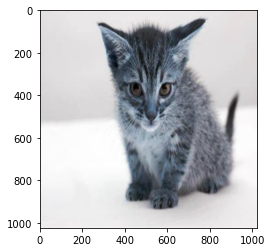

In [ ]:
# read pussy.jpg
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('../data/cat.jpg')
img = cv2.resize(img, (1024, 1024))
plt.imshow(img)
plt.show()

In [87]:
# convert to tensor
import torch
from torchvision import transforms

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = transforms.ToTensor()(img)
img

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


TypeError: Invalid shape (3, 1024, 1024) for image data

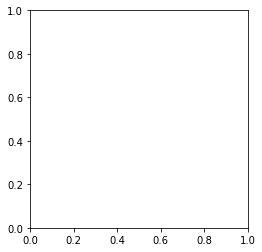

In [88]:
# show image
plt.imshow(img[0])

In [ ]:
# Pass the image through the autoencoder
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 1024, 1024])

In [89]:
img_encoded = autoencoder(img)

torch.Size([1, 64, 128, 128])


RuntimeError: Given transposed=1, weight of size [16, 3, 3, 3], expected input[1, 3, 1024, 1024] to have 16 channels, but got 3 channels instead